In [6]:
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80	# estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/100.0, yval, f'{yval:.2f}', va='bottom', color=color)

# Read the file and extract the win/losses
winloss_path = './logs/winloss.csv'
winloss = pd.read_csv(winloss_path, header=None, names=['WinLoss', 'Pass'])

# Calculate iterative winrate
p1_iter_wins, p2_iter_wins, p3_iter_wins = 0, 0, 0
p1_iter_losses, p2_iter_losses, p3_iter_losses = 0, 0, 0
p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses = [], [], []
for index, row in winloss.iterrows():
    if row['WinLoss'] == 'win':
        if row['Pass'] == 1:
            p1_iter_wins += 1
        elif row['Pass'] == 2:
            p2_iter_wins += 1
        elif row['Pass'] == 3:
            p3_iter_wins += 1
    elif row['WinLoss'] == 'loss':
        if row['Pass'] == 1:
            p1_iter_losses += 1
        elif row['Pass'] == 2:
            p2_iter_losses += 1
        elif row['Pass'] == 3:
            p3_iter_losses += 1
    # Calculate winrate at this point and store it in the list
    if (p1_iter_wins + p1_iter_losses) > 0:
        p1_iter_winlosses.append(p1_iter_wins / (p1_iter_wins + p1_iter_losses) * 100)
    if (p2_iter_wins + p2_iter_losses) > 0:
        p2_iter_winlosses.append(p2_iter_wins / (p2_iter_wins + p2_iter_losses) * 100)
    if (p3_iter_wins + p3_iter_losses) > 0:
        p3_iter_winlosses.append(p3_iter_wins / (p3_iter_wins + p3_iter_losses) * 100)
print(f'Pass 1 Winrates: {p1_iter_winlosses}')
print(f'Pass 2 Winrates: {p2_iter_winlosses}')
print(f'Pass 3 Winrates: {p3_iter_winlosses}')

# wins = winloss[winloss['WinLoss'] == 'win'].groupby('Pass').size()
# losses = winloss[winloss['WinLoss'] == 'loss'].groupby('Pass').size()
# p1_wins = wins.get(1, 0)
# p2_wins = wins.get(2, 0)
# p3_wins = wins.get(3, 0)
# p1_losses = losses.get(1, 0)
# p2_losses = losses.get(2, 0)
# p3_losses = losses.get(3, 0)
# print(f'Pass 1 Winrate: {p1_wins / (p1_wins + p1_losses) * 100:.2f}%')
# print(f'Pass 2 Winrate: {p2_wins / (p2_wins + p2_losses) * 100:.2f}%')
# print(f'Pass 3 Winrate: {p3_wins / (p3_wins + p3_losses) * 100:.2f}%')

# Read the file and extract the levelbeat
levelbeats_path = './logs/levelbeats.csv'
levelbeats = pd.read_csv(levelbeats_path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])

# Remove outliers from levelbeat, although keep in mind they do represent massive amounts of exploration at the beginning of training
dropped = 0
indexes = [index for index, win_time in enumerate(levelbeats['completion_timesteps']) if win_time > 150000]
for index in indexes:
    levelbeats = levelbeats.drop(index)
    print(f"Outlier dropped at index {index}")
    dropped += 1

# Find the split in the .csv between Pass 1 and Pass 2
with open(levelbeats_path, 'r') as file:
    lines = file.readlines()
split_index1 = lines.index('\n') - dropped
split_index2 = lines.index('\n', split_index1+1+dropped) - dropped -1
print("split_index1:", split_index1)
print("split_index2:", split_index2)

# Split the data corresponding to Pass 1 and Pass 2, find averages & 5 fastests
cutoff = 100
p1_completion_t = levelbeats['completion_timesteps'][:split_index1]
p2_completion_t = levelbeats['completion_timesteps'][split_index1:split_index2]
p3_completion_t = levelbeats['completion_timesteps'][split_index2:]
p1_training_t = levelbeats['training_timesteps'][:split_index1]
p2_training_t = levelbeats['training_timesteps'][split_index1:split_index2]
p3_training_t = levelbeats['training_timesteps'][split_index2:]

# Make sure dropping of indexes is correct
# print(p1_training_t)
# print(p2_training_t)
# print(p3_training_t)

# Acquire split data
average_pass1 = convert_to_time(p1_completion_t[-cutoff:].mean())
average_pass2 = convert_to_time(p2_completion_t[-cutoff:].mean())
average_pass3 = convert_to_time(p3_completion_t[-cutoff:].mean())
fastest_pass1 = levelbeats[:split_index1].nsmallest(5, 'completion_timesteps')
fastest_pass2 = levelbeats[split_index1:split_index2].nsmallest(5, 'completion_timesteps')
fastest_pass3 = levelbeats[split_index2:].nsmallest(5, 'completion_timesteps')

# Print out the data about the averages
print(f"Pass 1 average completion time: {convert_to_time(p1_completion_t.mean())} seconds")
print(f"Pass 2 average completion time: {convert_to_time(p2_completion_t.mean())} seconds")
print(f"Pass 3 average completion time: {convert_to_time(p3_completion_t.mean())} seconds")
print(f"Pass 1 average completion time for last {cutoff} wins: {average_pass1} seconds")
print(f"Pass 2 average completion time for last {cutoff} wins: {average_pass2} seconds")
print(f"Pass 3 average completion time for last {cutoff} wins: {average_pass3} seconds")

Pass 1 Winrate: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.090909090909092, 8.333333333333332, 7.6923076923076925, 7.142857142857142, 6.666666666666667, 6.25, 5.88235294117647, 5.555555555555555, 5.263157894736842, 5.0, 4.761904761904762, 4.545454545454546, 4.3478260869565215, 4.166666666666666, 4.0, 3.8461538461538463, 3.7037037037037033, 3.571428571428571, 3.4482758620689653, 3.3333333333333335, 3.225806451612903, 3.125, 3.0303030303030303, 2.941176470588235, 2.857142857142857, 2.7777777777777777, 2.7027027027027026, 2.631578947368421, 5.128205128205128, 5.0, 4.878048780487805, 4.761904761904762, 4.651162790697675, 6.8181818181818175, 6.666666666666667, 6.521739130434782, 6.382978723404255, 6.25, 6.122448979591836, 6.0, 5.88235294117647, 5.769230769230769, 5.660377358490567, 5.555555555555555, 5.454545454545454, 5.357142857142857, 5.263157894736842, 5.172413793103448, 5.084745762711865, 5.0, 4.918032786885246, 4.838709677419355, 4.761904761904762, 4.6875, 4.615384615384616,

ValueError: '\n' is not in list

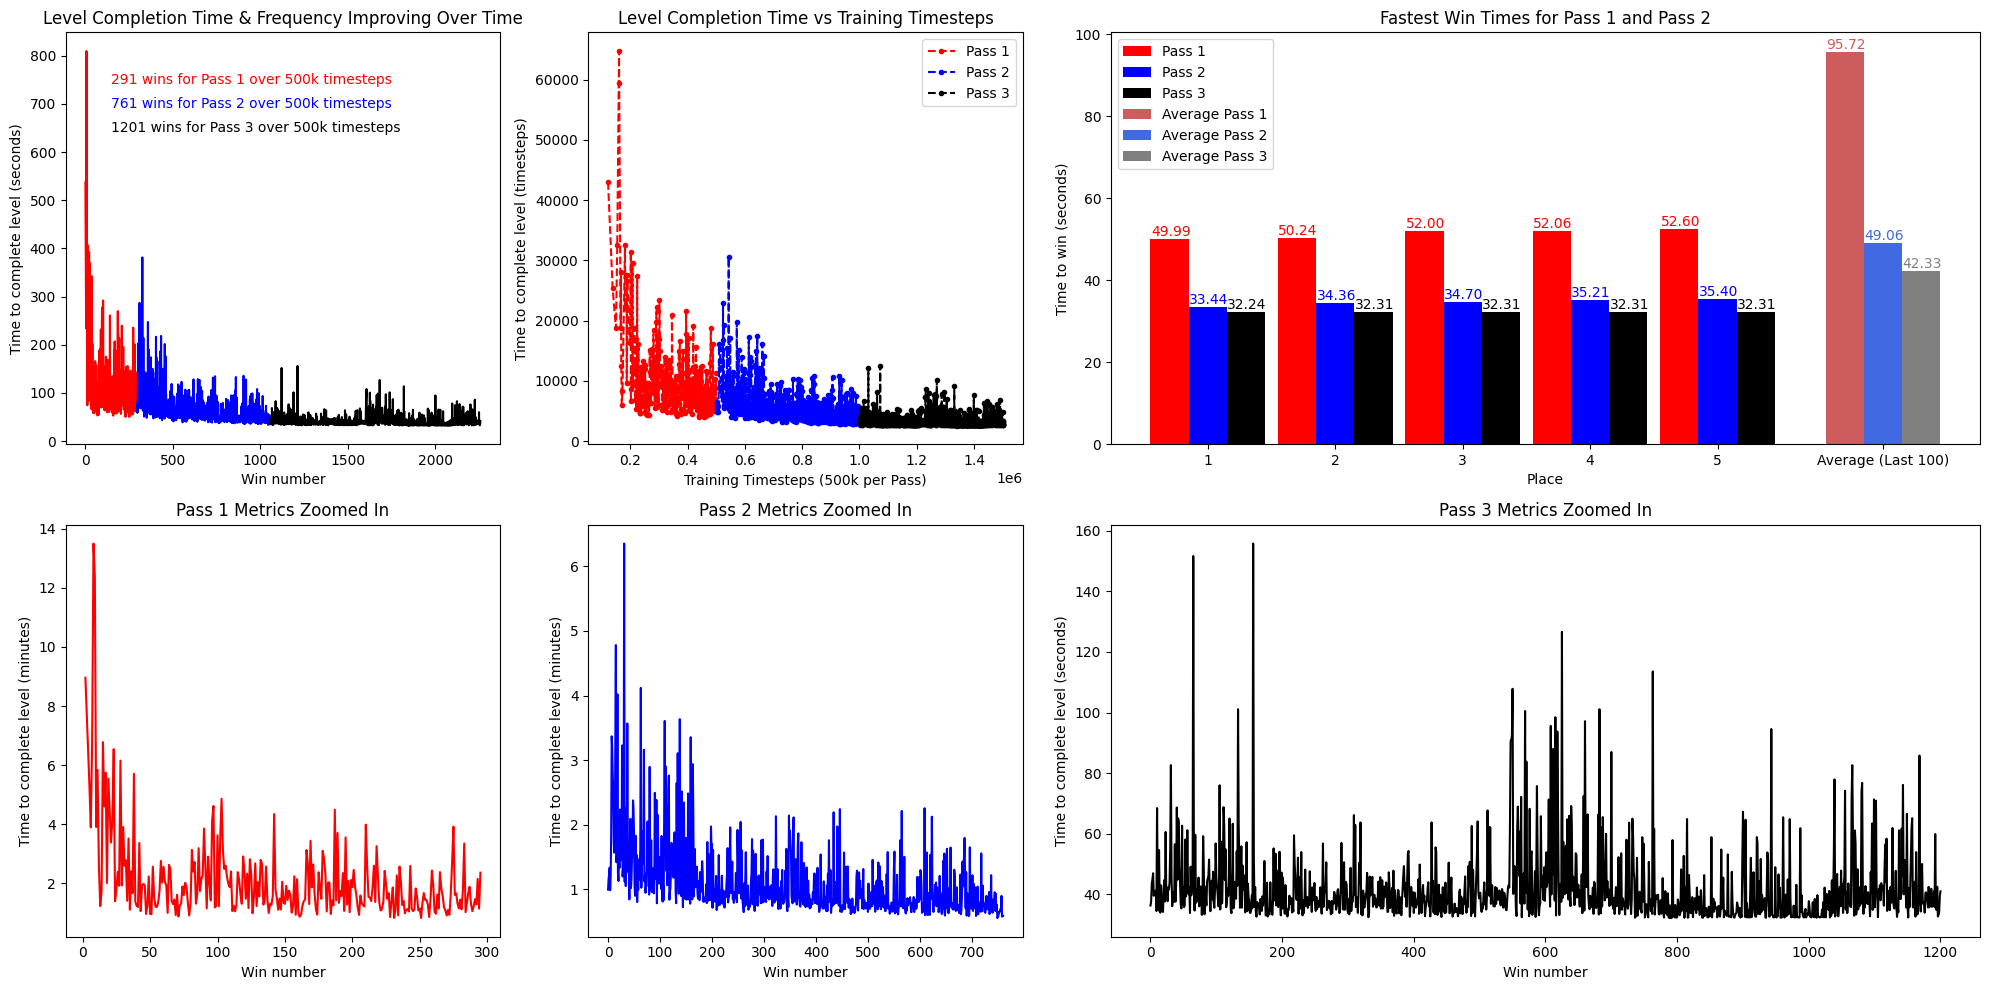

In [ ]:
#Customization
p1_color = "red"
p2_color = "blue"
p3_color = "black"
p1_color_average = "indianred"
p2_color_average = "royalblue"
p3_color_average = "gray"

# Graph setup
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 2], height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

# Graph level completion time and frequency improving over time
ax0.plot(convert_to_time(p1_completion_t), color=p1_color)
ax0.plot(convert_to_time(p2_completion_t), color=p2_color)
ax0.plot(convert_to_time(p3_completion_t), color=p3_color)
ax0.set_title('Level Completion Time & Frequency Improving Over Time')
ax0.set_ylabel('Time to complete level (seconds)')
ax0.set_xlabel('Win number')
ax0.text(150, 750, f'{len(p1_completion_t)} wins for Pass 1 over 500k timesteps', color=p1_color, verticalalignment='center', horizontalalignment='left')
ax0.text(150, 700, f'{len(p2_completion_t)} wins for Pass 2 over 500k timesteps', color=p2_color, verticalalignment='center', horizontalalignment='left')
ax0.text(150, 650, f'{len(p3_completion_t)} wins for Pass 3 over 500k timesteps', color=p3_color, verticalalignment='center', horizontalalignment='left')

# Graph level completion time vs training timesteps
ax1.plot(p1_training_t, p1_completion_t, linestyle='--', marker='.', label='Pass 1', color=p1_color)
ax1.plot(p2_training_t + 500000, p2_completion_t, linestyle='--', marker='.', label='Pass 2', color=p2_color)
ax1.plot(p3_training_t + 1000000, p3_completion_t, linestyle='--', marker='.', label='Pass 3', color=p3_color)
ax1.set_title('Level Completion Time vs Training Timesteps')
ax1.set_xlabel('Training Timesteps (500k per Pass)')
ax1.set_ylabel('Time to complete level (timesteps)')
ax1.legend(loc='upper right')

# Graph the bar chart, showing fastest speeds and average of the last 100 wins for each pass
width = 0.3
indices_pass1 = range(len(fastest_pass1))
indices_pass2 = [index + width for index in indices_pass1]
indices_pass3 = [index + width for index in indices_pass2]
bars1 =     ax2.bar(indices_pass1,                      convert_to_time(fastest_pass1['completion_timesteps']), width=width, label='Pass 1', color=p1_color)
bars2 =     ax2.bar(indices_pass2,                      convert_to_time(fastest_pass2['completion_timesteps']), width=width, label='Pass 2', color=p2_color)
bars3 =     ax2.bar(indices_pass3,                      convert_to_time(fastest_pass3['completion_timesteps']), width=width, label='Pass 3', color=p3_color)
bars1_avg = ax2.bar([max(indices_pass2) + 1],           [average_pass1],                                        width=width, label='Average Pass 1', color=p1_color_average)
bars2_avg = ax2.bar([max(indices_pass2) + 1 + width],   [average_pass2],                                        width=width, label='Average Pass 2', color=p2_color_average)
bars3_avg = ax2.bar([max(indices_pass3) + 1 + width],   [average_pass3],                                        width=width, label='Average Pass 3', color=p3_color_average)
label_bars(ax2, bars1, p1_color)
label_bars(ax2, bars2, p2_color)
label_bars(ax2, bars3, p3_color)
label_bars(ax2, bars1_avg, p1_color_average)
label_bars(ax2, bars2_avg, p2_color_average)
label_bars(ax2, bars3_avg, p3_color_average)
ax2.set_xticks(list(indices_pass2) + [max(indices_pass3) + 1])                          # Set x-ticks to indices and "Average" position
ax2.set_xticklabels(list(range(1, len(fastest_pass1) + 1)) + [f'Average (Last {cutoff})'])    # Set x-tick labels to index numbers and "Average"
ax2.set_title('Fastest Win Times for Pass 1 and Pass 2')
ax2.set_ylabel('Time to win (seconds)')
ax2.set_xlabel('Place')
ax2.legend()

# Graph the zoomed in metrics for each pass
ax3.plot(convert_to_time(p1_completion_t) / 60, color=p1_color)
ax3.set_title('Pass 1 Metrics Zoomed In')
ax3.set_ylabel('Time to complete level (minutes)')
ax3.set_xlabel('Win number')
x_values = range(len(convert_to_time(p2_completion_t)))
ax4.plot([x for x in x_values], convert_to_time(p2_completion_t) / 60, color=p2_color)
ax4.set_title('Pass 2 Metrics Zoomed In')
ax4.set_ylabel('Time to complete level (minutes)')
ax4.set_xlabel('Win number')
x_values = range(len(convert_to_time(p3_completion_t)))
ax5.plot([x for x in x_values], convert_to_time(p3_completion_t), color=p3_color)
ax5.set_title('Pass 3 Metrics Zoomed In')
ax5.set_ylabel('Time to complete level (seconds)')
ax5.set_xlabel('Win number')

# Show the graph
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()